In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
df=pd.read_csv('test_bat.csv', sep=',',header=0)

[1985-2012 Salary Data](https://www3.nd.edu/~lawlib/baseball_salary_arbitration/minavgsalaries/Minimum-AverageSalaries.pdf)
[2013-2019 Salary Data](https://www.statista.com/statistics/236213/mean-salaray-of-players-in-majpr-league-baseball/)

From the yearly salary averages, we compute the rate of inflation from 1 year to the next.

In [17]:
avg_salary = [371571,412520,412454,438729,497254,597537,851492,1028667,1076089,
              1168263,1110766,1119981,1336609,1398831,1611166,1895630,2138896,
              2295649,2372189,2313535,2476589,2699292,2824751,2925679,2996106,
              3014572,3095183,3210000,3390000,3690000,3840000,4380000,4470000,
              4520000]

inflation = (len(avg_salary)-1) * [0]
for i in range(len(avg_salary)-1):
    inflation[i] = float(avg_salary[i+1])/avg_salary[i]

From a given year, we adjust that price up to 2018 dollars by multiplying by the inflation of the average salary for each year up to 2018.

In [18]:
years = range(1985,2019,1)
for i in range(len(years)):
    year = years[i]
    mask = df['yearID']==year
    for adjustment in inflation[i:]:
        df.loc[mask, 'salary'] = df[mask]['salary'] * (adjustment)

Remove outliers. Numbers are given by 1.5x below Q1 and 1.5x above Q3 from full data set.

In [19]:
removed_outliers = (df.salary < np.percentile(df.salary, 75)*1.5) & (df.salary > np.percentile(df.salary, 25)/1.5)
df = df[removed_outliers]

Some entries in the dataframe are effectively empty, since they provide no useful information we throw them out.

In [20]:
cutoff = 5

mask = (df.G < cutoff) & (df.AB < cutoff) & (df.R < cutoff) & (df.H < cutoff) & (df.B2 < cutoff) & (df.B3 < cutoff) & \
       (df.HR < cutoff) & (df.RBI < cutoff) & (df.SB < cutoff) & (df.CS < cutoff) & (df.BB < cutoff) & (df.SO < cutoff) & \
       (df.IBB < cutoff) & (df.HBP < cutoff) & (df.SH < cutoff) & (df.SF < cutoff) & (df.GIDP < cutoff)
df = df.drop(df[mask].index)

Drop the last of the unused columns, and split into targets and samples.

In [21]:
df = df.drop(['num', 'playerID', 'yearID', 'stint', 'teamID', 'IgID', 'G', 'AB'], axis=1)

labels = list(df.columns)

y = np.array(df['salary'])

df = df.drop('salary', axis=1)

X = np.array(df)

 Additionally, we log transform the target data since it has a strong postive skewness.

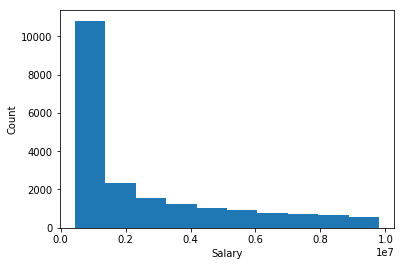

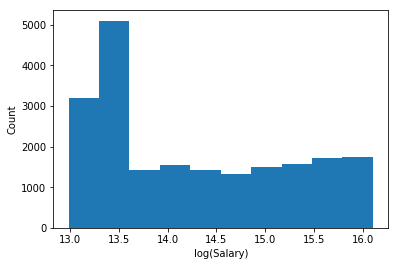

In [22]:
plt.hist(y)
plt.ylabel('Count')
plt.xlabel('Salary')
plt.show()

y=np.log(y)
plt.hist(y)
plt.ylabel('Count')
plt.xlabel('log(Salary)')
plt.show()

Split the data into testing and training sets.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

Initialize the random forest regressor, with some experimentally determined values. Fit the training data.

In [24]:
rf = RandomForestRegressor(bootstrap=True, min_samples_leaf=5, n_estimators=650, 
                           max_features='auto', min_samples_split=8, max_depth=40)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=650, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Make predictions on the testing set.

In [25]:
predictions = rf.predict(X_test)

Output mean square error between actual and predicted, and plot them.

0.847152949139
0.094164998184


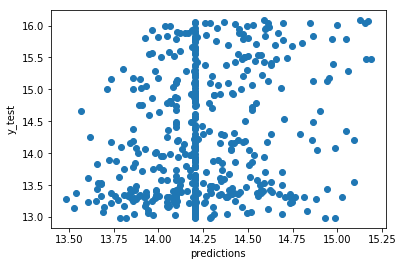

In [31]:
print mean_squared_error(y_test, predictions)
print rf.score(X_test, y_test)
sample = np.random.choice(range(len(y_test)), 500, replace=False)

plt.plot(predictions[sample], y_test[sample], 'o')
plt.xlabel('predictions')
plt.ylabel('y_test')
plt.show()

Feature Importance

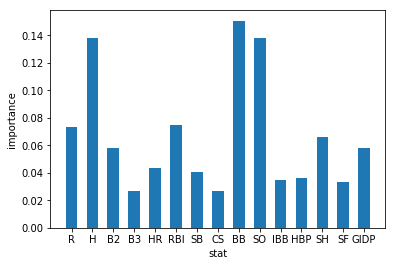

In [27]:
plt.bar(np.linspace(0,20,num=15), rf.feature_importances_, tick_label=labels[:15])
plt.ylabel('importance')
plt.xlabel('stat')
plt.show()